# Forward encoding model based on Pim Mostert Decoding toolbox



In [1]:
!pwd

/Users/junjieji/Documents/GitHub/master-thesis


In [2]:
import sys

# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
from decoding_toolbox_py.Helper_funcs import DecToolbox as dt
import mne
import os
import random

from statsmodels.tsa.stattools import coint


In [3]:
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

# Variables

In [4]:
''' VARIABLES '''

# dataset = 'matlab'
dataset = 'eeg'

numC = 8
angles = [i * 180./numC for i in range(numC)]
x_labels = np.array(angles)

resample = True # speeds up the procees but showing worse results overall
if resample: resample_frequency = 100 # in Hz, original freq is 500Hz

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.1
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

# Loading & preparing orientation data

In [5]:
if dataset == 'matlab':
    path = 'decoding-toolbox_matlab/data/testdata_orientation.mat' 
    ori_data = mat73.loadmat(path)
    Y = ori_data['Y']
    X = ori_data['X']
    time = ori_data['time']
    label = ori_data['label']
else:
    '''EEG Dataset'''
    amount_of_subjects = 26 # Change the range so the process is faster
    singular_subject = 1
    if amount_of_subjects > 26: amount_of_subjects = 26
    subjs_list = ['s{:02d}'.format(i) for i in range(1, amount_of_subjects+1) if i != 6 ] 

    path = 'Cond_CJ_EEG'
    # Read main_epo.fif files and create a list of averaged epochs
    epochs = []
    all_epochs = []
    all_rawdata = []
    all_st_epochs = []
    all_st_rawdata = []

    for subject_id in subjs_list:
        preproc_path = os.path.join(path, subject_id)
        
        epoch = mne.read_epochs(os.path.join(preproc_path, 'main_epo.fif'), verbose=False)
        epochs.append(epoch.average())

        all_epochs.append(epoch)
        all_rawdata.append({'epoch_dat': epoch.get_data(), 'metadata': epoch.metadata})

        st_epoch = mne.read_epochs(os.path.join(preproc_path, 'mainstim_epo.fif'), verbose=False)
        # print(st_epoch.info['sfreq'])
        if resample: 
            print('Frequency before:', st_epoch.info['sfreq'])
            st_epoch = st_epoch.resample(resample_frequency)
            print('Frequency after:' ,st_epoch.info['sfreq'])
        all_st_epochs.append(st_epoch)
        all_st_rawdata.append({'epoch_dat': st_epoch.get_data(), 'metadata': st_epoch.metadata})

    gvaverage = mne.grand_average(epochs[:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequency after: 100.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Frequency before: 500.0
Frequen

In [6]:
if dataset == 'eeg':
    print(epoch.metadata.shape)
    display(epoch.metadata.head())

(230, 35)


,index,subj,nblock,ntrial,nrep,trial_type,cond-1,cond,rDV,DV,...,d5,d6,o1,o2,o3,o4,o5,o6,confi-1,conf_lvl-1
883,0,s26,0,0,0,repeat,0,0,0.367181,-0.22,...,-0.922096,-0.066479,0.036,2.735,0.727,2.918,3.111,2.775,0.00,L
896,1,s26,0,0,1,repeat,0,0,0.367181,-0.22,...,-0.922096,-0.066479,0.036,2.735,0.727,2.918,3.111,2.775,1.00,H
909,2,s26,0,0,2,repeat,0,0,0.367181,-0.22,...,-0.922096,-0.066479,0.036,2.735,0.727,2.918,3.111,2.775,1.00,H
922,3,s26,0,1,0,nonrepeat,0,1,0.624320,0.12,...,-0.456091,-0.184608,2.221,2.377,2.878,1.132,2.928,1.891,1.00,H
935,4,s26,0,1,1,nonrepeat,1,1,0.624320,0.12,...,-0.456091,-0.184608,2.221,2.377,2.878,1.132,2.928,1.891,-0.25,L


In [7]:
if dataset == 'eeg':
    print(st_epoch.metadata.shape)
    display(st_epoch.metadata.head())

(1473, 23)


,subj,trial_type,nblock,ntrial,nrep,stim_cond,cond-1,cong_deci,cong_stim,cond,...,corr-1,correct,confi,conf_lvl,correct-1,RT,stim,dv,orient,ov
885,s26,repeat,0,0,0,C,0,C,C,0,...,0,1,1.0,H,0,2.137953,d1,-0.908327,2.062648,-0.954163
886,s26,repeat,0,0,0,D,0,I,I,0,...,0,1,1.0,H,0,2.137953,d2,0.035380,156.703957,-0.482310
887,s26,repeat,0,0,0,D,0,I,I,0,...,0,1,1.0,H,0,2.137953,d3,0.851290,41.654032,-0.074355
888,s26,repeat,0,0,0,C,0,C,C,0,...,0,1,1.0,H,0,2.137953,d4,-0.430626,167.189085,-0.715313
889,s26,repeat,0,0,0,C,0,C,C,0,...,0,1,1.0,H,0,2.137953,d5,-0.922096,178.247170,-0.961048


# Procedure for one subject and a specific time

In [8]:
if dataset == 'eeg':
    ival = singular_subject
    Y = all_st_rawdata[ival]['epoch_dat']
    Y = np.einsum('kji->jik', Y)
    # Y = Y[0:24,:,:]
    Y = np.delete(Y, 25, axis=0) # Delete eye channel because signals are 1e3 higher than the other series
    X = np.array(all_st_rawdata[ival]['metadata'].orient)
    time = all_st_epochs[ival].times
    label = all_st_epochs[ival].ch_names # Redundant because all labels are the same for all subj
    X = np.digitize(X, bins = np.array(angles))-1.
    # else:
    #     ival = 0
    #     YY = all_st_rawdata[ival]['epoch_dat']
    #     YY = np.einsum('kji->jik', YY)
    #     XX = np.array(all_st_rawdata[ival]['metadata'].orient)
    #     tt = all_st_epochs[ival].times
    #     ll = all_st_epochs[ival].ch_names
    #     for ival in range(1, len(subjs_list)):
    #         YY2 = all_st_rawdata[ival]['epoch_dat']
    #         YY2 = np.einsum('kji->jik', YY2)
    #         XX2 = np.array(all_st_rawdata[ival]['metadata'].orient)
    #         tt2 = all_st_epochs[ival].times
    #         YY = np.concatenate((YY,YY2),axis=2)
    #         XX = np.concatenate((XX,XX2),axis=0)
    #         tt = np.concatenate((tt,tt2),axis=0)
    #     new_XX = np.digitize(XX, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) )-1.

In [9]:
phi = X * (180./8);  # We want the degrees data because its the one used for the stim_features

numF, numT, numN = Y.shape

In [10]:
sel_t = np.where(time >=.2)[0][0];
#sel_t = 170
print(sel_t)

31


In [11]:
def train_encoder(X, Y, cfg):
#   [decoder] = train_encoder(X, Y, cfg)
#    Trains a linear decoder "beamformer style" to optimally recover the latent components as 
#    prescribed in X. Several decoders may be trained indepedently, corresponding to several
#    latent components.
#
#    X           Vector or matrix of size C x N, where C is the number of components and N is
#                the number of trials, that contains the expected/prescribed component activity
#                in the training data.
#    Y           Matrix of size F x N, where F is the number of features, that contains the
#                training data.
#    cfg         Configuration struct that can possess the following fields:
#                ['gamma'] = [scalar]                Shrinkage regularization parameter, with range [0 1]. 
#                                                 No default given.
#                ['returnPattern'] = 'yes' or 'no'   Whether the spatial patterns of the components should
#                                                 be returned. Default = 'no';
#                ['demean'] = 'yes' or 'no'          Whether to demean the data first (per feature, over
#                                                 trials). Default = 'yes';.
#
#    decoder     The (set of) decoder(s), that may be passed on to an appropriate decoding function,
#                e.g. decode_beamformer. It may contain a field .pattern of size C x F
#
#    See also DECODE_BEAMFORMER.
#    Created by Pim Mostert, 2016 in Matlab. Exported to Python by Alexis Pérez Bellido, 2022 
    Y = Y.T
    X = X.T
    numC = X.shape[1]
    numF = Y.shape[1]
    decoder = dict()
    gamma = cfg['gamma']

    # demean activity in each trial
    if 'demean' not in cfg:
        cfg['demean'] = True

    if 'returnPattern' not in cfg:
        cfg['returnPattern'] = False

    if  cfg['demean']:
        Ym = Y.mean(axis=0, keepdims=True)
        Y = Y - np.repeat(Ym, axis = 0, repeats = Y.shape[0])
        decoder['dmY'] = Ym.T # save demeaned Y for posterior inspection
    
    if cfg['returnPattern']:
        decoder['pattern'] = np.zeros([numF, numC]) 

    decoder['W'] = np.zeros([numC, numF]) # weights empty matrix


    for ic in range(numC):
        l = (np.dot(X[:,ic].T, X[:,ic])**-1) * np.dot(X[:,[ic]].T, Y) 
        if cfg['returnPattern']:
            decoder['pattern'][:, ic] = l
        # Estimate noise (what is not explained by the regressors coefficients)
        N = Y - X[:,[ic]] * l
        # Estimate noise covariance
        S = np.cov(N,rowvar=False).copy() # rowvar is necessary to get the correct covariance matrix shape
        #  Regularize
        S = (1-gamma)*S + gamma*np.eye(numF) * np.trace(S)/numF #% [w,d] = eig(S);  eigenvalues -> pdiag(d)
        decoder['W'][ic, :] = np.dot(l,np.linalg.inv(S))
    return decoder

In [12]:
G = X.copy()
CONDS = np.unique(G);
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

dat = dict()
dat['X_train'] = G[ FoldsIdx[0]['train_index']]
dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['train_index']])
dat['phi_train'] = phi[ FoldsIdx[0]['train_index']]

dat['X_test'] = G[ FoldsIdx[0]['test_index']]
dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['test_index']])
dat['phi_test'] = phi[ FoldsIdx[0]['test_index']]

design, sortedesign = dt.stim_features(dat['phi_train'], cfg_stim)
decoder = train_encoder(design, dat['Y_train'], cfg_train)
Xhat = dt.test_encoder( decoder, dat['Y_test'], cfg_test)

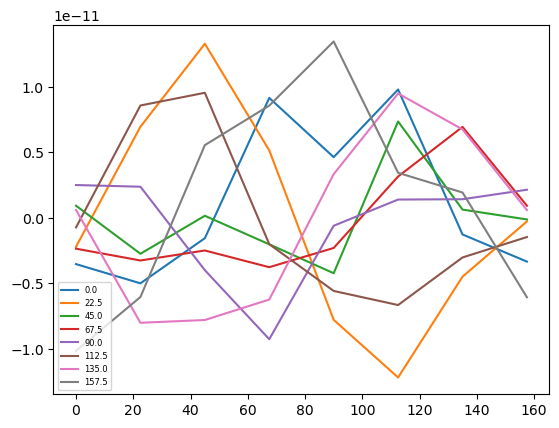

In [13]:
m = np.zeros((numC,numC))
for ic in range(numC):
    m[:,ic] =  np.mean( Xhat[:, np.where(dat['X_test'] == ic )[0]], axis = 1)
plt.plot(x_labels, m)
plt.legend(x_labels, loc=3, prop={'size': 6})

__Preparing data for plotting results__

Re-alligning predictions for trials with identical orientation

In [14]:
Xhat_centered = 0*Xhat.copy()
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:,np.where(dat['X_test'] == ic)] = np.roll(Xhat[:,np.where(dat['X_test'] == ic)], -ic, axis = 0)

In [15]:
m_centered = np.zeros((numC,numC))
for ic in range(numC):
   m_centered[:,ic] =  np.mean( Xhat_centered[:, np.where(dat['X_test'] == ic)[0]], axis = 1)

In [16]:
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [17]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

-0.07123127992522844

Getting mean orientation values for each stimulus bin

In [18]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[np.where(dat['X_test'] == ic)[0]] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

Plotting results

[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

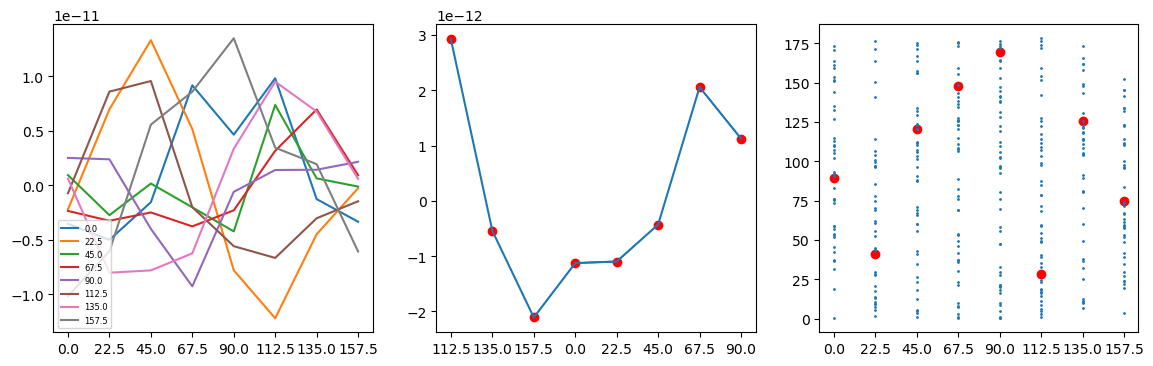

In [19]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(dat['phi_test'], theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


# Cross validation encoder in all time values

In [20]:
print(G)

[5. 1. 6. ... 4. 0. 0.]


In [21]:
G = X.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

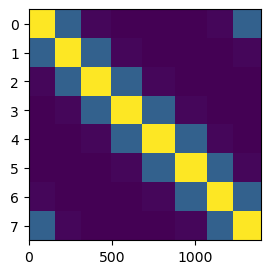

In [22]:
design, sortedesign = dt.stim_features(phi, cfg_stim)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [23]:
cfg = dict()
cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
cfg['cfgD'] = {'demean' : 'traindata'}
Xhat = dt.CV_encoder(design, Y, sel_t, cfg, FoldsIdx)

In [24]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == ic], axis = 1)

Re-alligning predictions for trials with identical orientation

In [25]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == ic] = np.roll(Xhat[:,G == ic], -ic, axis = 0)
    m_centered[:,ic] =  np.mean( Xhat_centered[:,  G == ic], axis = 1)

In [26]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [27]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

0.01875812181533673

Getting mean orientation values for each stimulus bin

In [28]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[G == ic] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

Plotting results

[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

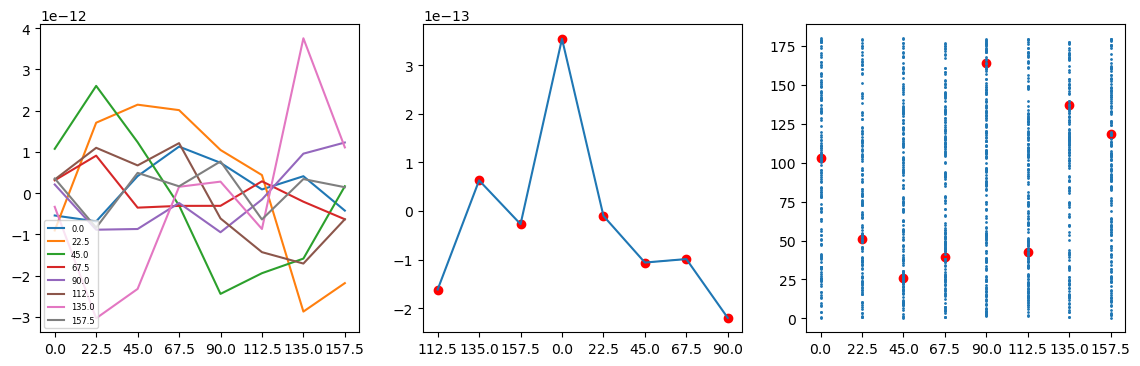

In [29]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(phi, theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


# Temporal dimension decoding

In [30]:
G = X.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

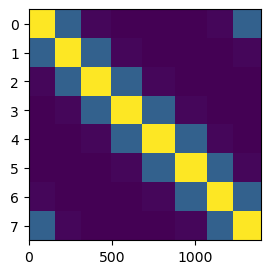

In [31]:
numC = 8 # how many channels to use
design, sortedesign = dt.stim_features(phi, cfg_stim)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [32]:
# print(crossval)

In [33]:
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it] = dt.CV_encoder(design, Y, it, cfg, FoldsIdx)

In [34]:
m = np.zeros((numC,numC, numT))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == ic,:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [35]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == ic,:] = np.roll(Xhat[:,G == ic,:], -ic, axis = 0)
    m_centered[:,ic, : ] =  np.mean( Xhat_centered[:,  G == ic, :], axis = 1)

In [36]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

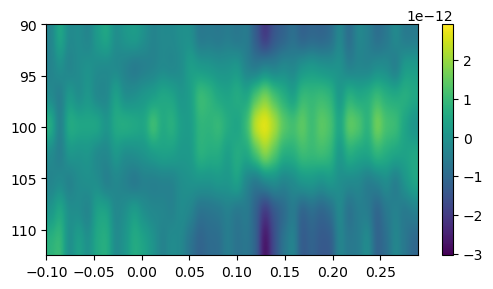

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Xhat_shiftedmean,aspect='auto', interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()

# Crossmodal temporal generalization decoding

In [38]:
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it, :] = dt.CV_TG_encoder(design, Y, it, cfg, FoldsIdx)

'''
macbook M1 speed
Takes 4 min for matlab dataset
takes 1 min for eeg dataset
'''

'\nmacbook M1 speed\nTakes 4 min for matlab dataset\ntakes 1 min for eeg dataset\n'

In [39]:
m = np.zeros((numC, numC, numT, numT))
for ic in range(numC):
   m[:,ic, :, :] =  np.mean( Xhat[:, G == ic,:,:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [40]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == ic,:, :] = np.roll(Xhat[:,G == ic,:, :], -ic, axis = 0)
    m_centered[:,ic, : , : ] =  np.mean( Xhat_centered[:,  G == ic, :, :], axis = 1)

'''1 min mac'''

'1 min mac'

Plotting diagonal values

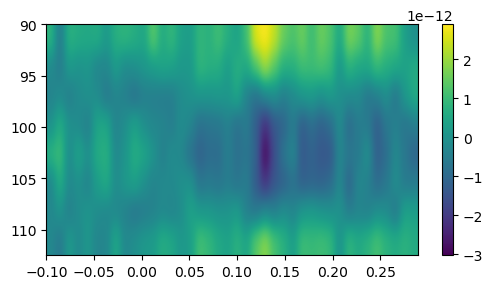

In [41]:
diagonal_vals =  m_centered[:,:,range(numT),range(numT)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(np.mean(diagonal_vals, axis = 1),aspect='auto', interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()

Correlation between actual and predicted orientation values

In [42]:
r = np.zeros((numT, numT))

for it1 in range(numT):
    for it2 in range(numT):
        # Kernel to back project channel outputs to orientation space
        kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
        Z = kernel @ Xhat[:,:, it1, it2]

        theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

        rs = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
        r[it1, it2] = np.abs(rs) * np.cos(np.angle(rs))
        r
'''1 min mac'''

'1 min mac'

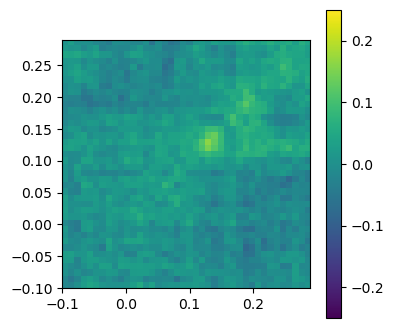

In [43]:
time_labels = [0, 0.2, 0.4, 0.6]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(r, aspect= 1, interpolation = None, vmin = -0.25, vmax = 0.25, origin = 'lower',extent=[time[0],time[-1],time[0],time[-1]])
plt.colorbar()